In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import talib
import warnings
warnings.filterwarnings("ignore")

In [2]:
def getData(stockName,period='120d',interval='1h'):
    return yf.download(tickers=stockName, period=period, interval=interval)

In [3]:
def find_items(items, keyword):
    matching_items = []
    for item in items:
        if keyword in item:
            matching_items.append(item)
    return matching_items

In [94]:
df = getData('ISCTR.IS').reset_index()

[*********************100%***********************]  1 of 1 completed


<Axes: >

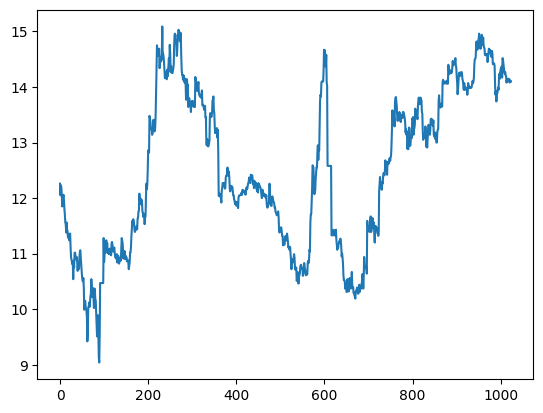

In [95]:
df['Close'].plot()

In [96]:
df['pct']=df['Close'].pct_change()
df['label']=np.where(df['pct']>0,1,0)

In [97]:
df['label'].value_counts()

label
0    566
1    458
Name: count, dtype: int64

# Creating MA

In [98]:
for i in list(range(3,100)):
    df[f'SMA_{i}'] = talib.SMA(df['Close'], timeperiod=i)
    df[f'EMA_{i}'] = talib.EMA(df['Close'], timeperiod=i)

In [99]:
ma_cols=df.columns[df.columns.str.startswith('EMA')].to_list() + df.columns[df.columns.str.startswith('SMA')].to_list()

for m in ma_cols:
    df[f'{m}_above_close']=np.where(df[f'{m}']>df['Close'],1,0)

In [100]:
from itertools import combinations
for c,b in list(set(combinations(ma_cols,2))):
    df[f'{c}_above_{b}']=np.where(df[c]>df[b],1,0)

In [101]:
above_cols=find_items(df.columns,'above')

In [102]:
for ac in above_cols:
    for s in [1]:
        df[f'{ac}_shift_{s}']=df[ac].shift(s)
        
for mc in ma_cols:
    for s in [1]:
        df[f'{mc}_shift_{s}']=df[mc].shift(s)

# Model and Feature Importance

In [103]:
shift_cols = find_items(df.columns,'shift') + ['label']

In [104]:
df = df[shift_cols]
df

EMA_3_above_close_shift_1  EMA_4_above_close_shift_1  \
0                           NaN                        NaN   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   
...                         ...                        ...   
1019                        1.0                        1.0   
1020                        0.0                        0.0   
1021                        1.0                        1.0   
1022                        0.0                        0.0   
1023                        1.0                        1.0   

      EMA_5_above_close_shift_1  EMA_6_above_close_shift_1  \
0                           NaN                        NaN   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   
...                         ...                        ...   
1019                        1.0                        1.0   
1020                        0.0                        1.0   
1021                        1.0                        1.0   
1022                        0.0                        1.0   
1023                        1.0                        1.0   

      EMA_7_above_close_shift_1  EMA_8_above_close_shift_1  \
0                           NaN                        NaN   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   
...                         ...                        ...   
1019                        1.0                        1.0   
1020                        1.0                        1.0   
1021                        1.0                        1.0   
1022                        1.0                        1.0   
1023                        1.0                        1.0   

      EMA_9_above_close_shift_1  EMA_10_above_close_shift_1  \
0                           NaN                         NaN   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
...                         ...                         ...   
1019                        1.0                         1.0   
1020                        1.0                         1.0   
1021                        1.0                         1.0   
1022                        1.0                         1.0   
1023                        1.0                         1.0   

      EMA_11_above_close_shift_1  EMA_12_above_close_shift_1  ...  \
0                            NaN                         NaN  ...   
1                            0.0                         0.0  ...   
2                            0.0                         0.0  ...   
3                            0.0                         0.0  ...   
4                            0.0                         0.0  ...   
...                          ...                         ...  ...   
1019                         1.0                         1.0  ...   
1020                         1.0                         1.0  ...   
1021                         1.0                         1.0  ...   
1022                         1.0                         1.0  ...   
1023                         1.0                         1.0  ...   

      SMA_91_shift_1  SMA_92_shift_1  SMA_93_shift_1  SMA_94_shift_1  \
0                NaN             NaN             NaN             NaN   
1                NaN             NaN     

In [105]:
from  sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error as accuracy_score,confusion_matrix,classification_report

tscv = TimeSeriesSplit(n_splits=3)

df.reset_index(drop=True, inplace=True)
acs = []

for i, (train_index, valid_index) in enumerate(tscv.split(df)):
    train, valid = df.iloc[train_index], df.iloc[valid_index]
    
    X_train = train.drop(columns=['label'])
    y_train = train['label']
    
    X_val = valid.drop(columns=['label'])
    y_val = valid['label']

    model = lgb.LGBMClassifier()
    model.fit(X_train,y_train)
    pred = model.predict(X_val)
    print(confusion_matrix(y_val,pred))
    print(classification_report(y_val,pred))
    acs.append(pd.DataFrame(model.feature_importances_,model.feature_name_,columns=[f'{i}']))
    

[[99 50]
 [68 39]]
              precision    recall  f1-score   support

           0       0.59      0.66      0.63       149
           1       0.44      0.36      0.40       107

    accuracy                           0.54       256
   macro avg       0.52      0.51      0.51       256
weighted avg       0.53      0.54      0.53       256

[[82 55]
 [67 52]]
              precision    recall  f1-score   support

           0       0.55      0.60      0.57       137
           1       0.49      0.44      0.46       119

    accuracy                           0.52       256
   macro avg       0.52      0.52      0.52       256
weighted avg       0.52      0.52      0.52       256

[[90 43]
 [76 47]]
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       133
           1       0.52      0.38      0.44       123

    accuracy                           0.54       256
   macro avg       0.53      0.53      0.52       256
weighted avg     

In [106]:
fe=pd.concat(acs,axis=1)
fe['row_sums'] = fe.sum(axis=1)
fe['prod'] = fe.prod(axis=1)

In [107]:
pp = list(fe.sort_values(by='prod',ascending=False).head(20).index)

In [108]:
[i.split('_shift')[0] for i in pp]

['SMA_3_above_close',
 'EMA_4_above_SMA_4',
 'EMA_6',
 'EMA_3',
 'SMA_9',
 'SMA_15',
 'EMA_5_above_SMA_5',
 'EMA_9',
 'EMA_3_above_SMA_3',
 'EMA_6_above_close',
 'EMA_8_above_SMA_7',
 'SMA_22',
 'SMA_6_above_SMA_7',
 'SMA_3_above_SMA_4',
 'SMA_7',
 'EMA_7_above_SMA_7',
 'SMA_3',
 'SMA_4_above_SMA_5',
 'SMA_6',
 'EMA_29']